# Project 3: Web APIs & NLP

### I. Problem Statement

A legal firm is looking to create a contact form for their pro-bono legal clinic’s website. I have been hired to create a machine learning classification model for this new feature that would help filter out non-legal inquiries.

### II. Importing Libraries

In [1]:
import re
import time
import datetime
import requests
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from sklearn.svm import SVC
try:
    import cPickle as pickle
except ImportError: 
    import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score

pd.options.display.max_colwidth = 200

### III. Scraping Reddit and Reading-in Data

In [2]:
# Thanks Gwen for the example!

def get_reddit_submission(subreddit,kind="submission",is_self=True):
    
    '''Function takes in 3 parameters; name of subreddit, kind of data to be scraped (default submission)
    and filters out non-self created submission by default (can be filtered to is_self = False) and returns
    csv file of 5,000 unique reddit posts from the subreddit'''
    
    # columns to be saved onto dataframe
    subfield = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score']
    base_url = f'https://api.pushshift.io/reddit/search/{kind}'
    ls = []
    
    while len(ls) < 5000:
        if len(ls) == 0:
            # pulling the max number of posts per iteration where selftext / body post have not been removed by moderator
            url = f'{base_url}?subreddit={subreddit}&size=100&is_self={is_self}&selftext:not=[removed]'
        else: 
            # pulling posts with the same criteria above posted before the last post pulled and appended
            url = f'{base_url}?subreddit={subreddit}&size=100&is_self={is_self}&selftext:not=[removed]&before={ls[-1]["created_utc"]}'
        # get json formatting of data
        res = requests.get(url)
        try: 
            assert(res.status_code == 200)
            json = res.json()['data']
            for dic in json:
                if dic not in ls:
                    ls.append(dic) # appending only unique posts
                else:
                    pass
            print(f'Posts collected: {len(ls)}')
            time.sleep(2)
        except:
            print(f'Error Status Code: {res.status_code}')

    df = pd.DataFrame(ls) # make dataframe out of lidt of dictionaries of subreddit post data
    df = df[subfield] # only taking important columns
    df.drop_duplicates(inplace = True) # sanity to remove potential duplicates
    df['timestamp'] = df["created_utc"].map(dt.date.fromtimestamp) # utc converted to timestamp
    df.drop(columns=["created_utc"],inplace=True) # dropping created_utc column
    df = df.reset_index(drop=True) # reset index
    return df.to_csv(f'./dataset/{subreddit}.csv',index=False) # returns csv file stored in dataset folder

In [3]:
# # get most recent 5,000 posts on r/LegalAdvice.
# # note that this is commented out so that the data used within the models do not constantly change
# get_reddit_submission("legaladvice")

In [4]:
# reading in legal advice data
legal = pd.read_csv('../dataset/legaladvice.csv')
legal.shape

(5000, 7)

In [5]:
# # get most recent 5,000 posts on r/Malicious Compliance
# # note that this is commented out so that the data used within the models do not constantly change
# get_reddit_submission("maliciouscompliance")

In [6]:
# reading in malicious compliance data
mc = pd.read_csv('../dataset/maliciouscompliance.csv')
mc.shape

(5000, 7)

### III. Data Cleaning and Pre-Processing

For the purposes of the analysis, we must first combine the two subreddit dataframes, as seen below:

In [7]:
joint_df = pd.concat([legal,mc],axis=0)
joint_df = joint_df.reset_index(drop=True)

joint_df.shape

(10000, 7)

Because the model requested needs to be one that can identify legal problems, we create a binary classification column with our target class of 1 for r/LegalAdvice posts and 0 for r/MaliciousCompliance posts.

In [8]:
joint_df["class"] = [1 if cell == "legaladvice" else 0 for cell in joint_df["subreddit"]]
joint_df.drop(columns=["subreddit"], inplace = True)

In [9]:
joint_df.head()

,title,selftext,author,num_comments,score,timestamp,class
0,[Serious] MA - father just backed into GFs car.,"my father who shouldn't be driving just backed his truck up and hit GFs car about a hour ago, hes angry she was there and shes angry he hit her. \n\n\nthis takes place at our home and in the driv...",TJzzz,0,1,2021-04-23,1
1,Can I return a private party purchase of a boat?,I purchased a boat in Oregon and found out the seller lied about a handful of things. Can I return the boat?,Vast-Lost,0,1,2021-04-23,1
2,Can the police arrest you for recording a crime scene they're working on? (TX),I'm a manager at a restaurant. Someone got shot in the parking lot at my job. The police shows up and closes down the entire place. I call my boss to let them know that we needed to close because ...,PuzzleheadedTaste726,0,1,2021-04-23,1
3,Are hospitals required to health screen/temp check employees?,Hospital I work at has no such regulations regarding COVID.,forrborne,0,1,2021-04-23,1
4,Settling a minor fender bender without insurance (FL),"I got rear ended and the damage to my car is very minimal—I think. It looks like the bumper just popped out a bit and there’s a few scratches. My car is also an old beater, a 2008 civic that is in...",pleing1,0,1,2021-04-23,1


#### Checking for nulls

There are 250 null values for selftext, which means there are 250 title only posts. Understanding that this may become an issue when combining both title and selftext into one document (because adding Nonetype to a string returns None), nulls are to be replaced with empty strings ("").

In [10]:
joint_df.isnull().sum()

title             0
selftext        250
author            0
num_comments      0
score             0
timestamp         0
class             0
dtype: int64

In [11]:
joint_df[joint_df["selftext"].isna()].head()

,title,selftext,author,num_comments,score,timestamp,class
5,Quick lane didnt put the oil filter on right and seized the engine. It's a custom engine. Their filter is sitting on my skid plate. Should I be trying to settle with them for the amount it would t...,NaN,xJD88x,0,1,2021-04-23,1
92,Buy LAC now to make rich,NaN,Bull-Start,0,1,2021-04-23,1
132,"Does the abuse of lizards (not pet lizards, like the kind you’d see outside) count as animal abuse?",NaN,Neil-Ward,1,1,2021-04-23,1
140,I was involved in an injury accident due to faulty brakes on an e-scooter I purchased recently. The vendor is refusing to repair the scooter and is claiming that the accident was my fault even tho...,NaN,LovelyCaramel,2,1,2021-04-23,1
157,Is it illegal to create/buy/possess a fake COVID-19 vaccination record card?,NaN,sugitime,4,1,2021-04-23,1


In [12]:
joint_df["selftext"].fillna("",inplace=True)
joint_df.isnull().sum()

title           0
selftext        0
author          0
num_comments    0
score           0
timestamp       0
class           0
dtype: int64

#### Removing / replacing unusual characters / text

Testing RegEx combinations on the following [site](https://regex101.com), we were able to figure out how to replace / remove particular non-alphanumeric characters the best way possible, without removing ones that would be valuable for within the text (i.e. periods between numbers used to show decimal place or hyphenated words). We were also able to replace emojis to text using the *convert_emojis_to_word* function below.

In [13]:
# replace emoji with text
# source: https://studymachinelearning.com/text-preprocessing-handle-emoji-emoticon/ (Thanks Amy!)
with open('../dataset/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

In [14]:
%%time
for column in ["title","selftext"]:
    # replace emojis into words
    joint_df[column] = joint_df[column].map(convert_emojis_to_word)
    # removing link
    joint_df[column] = joint_df[column].replace("https://[\S]+","",regex=True)
    joint_df[column] = joint_df[column].replace("http://[\S]+","",regex=True)
    joint_df[column] = joint_df[column].replace("www.[\S]+","",regex=True)
    # removing character code for a Zero-witdh space
    joint_df[column] = joint_df[column].replace("&amp;#x200B;","",regex=True).replace("\xa0"," ",regex=True)
    # replacing line breaks with space
    joint_df[column] = joint_df[column].replace("\n"," ",regex=True)
    # replace % with -pct due to RegEx
    joint_df[column] = joint_df[column].replace("%","-pct",regex=True)
    # replace + with plus due to RegEx
    joint_df[column] = joint_df[column].replace("\+","plus",regex=True)
    # replace [ with space due to RegEx
    joint_df[column] = joint_df[column].replace("\["," ",regex=True)
    # replace ) with space due to RegEx
    joint_df[column] = joint_df[column].replace("\)"," ",regex=True)
    # replace — with space due to RegEx
    joint_df[column] = joint_df[column].replace("—"," ",regex=True)
    # replacing some common symbols
    joint_df[column] = joint_df[column].replace("&lt;","less_than_sign",regex=True).replace("&gt;","greater_than_sign",regex=True).replace("&le;","less_than_or_equals_to_sign",regex=True).replace("&ge;","greater_than_or_equals_to_sign",regex=True)
    # remove non-alphanumeric characters that isn't a value (i.e. decimal places, commas within numbers, etc.)
    joint_df[column] = joint_df[column].replace("\W+[^A-z0-9#$%]"," ",regex=True)
    joint_df[column] = joint_df[column].map(lambda x: x[:-1] if x != "" and x[-1] in ["?",".",'"',"!",":"] else x)

CPU times: user 17min 33s, sys: 1.76 s, total: 17min 34s
Wall time: 17min 35s


In [15]:
joint_df.head()

,title,selftext,author,num_comments,score,timestamp,class
0,Serious MA father just backed into GFs car,my father who shouldn't be driving just backed his truck up and hit GFs car about a hour ago hes angry she was there and shes angry he hit her this takes place at our home and in the driveway GFs ...,TJzzz,0,1,2021-04-23,1
1,Can I return a private party purchase of a boat,I purchased a boat in Oregon and found out the seller lied about a handful of things Can I return the boat,Vast-Lost,0,1,2021-04-23,1
2,Can the police arrest you for recording a crime scene they're working on TX,I'm a manager at a restaurant Someone got shot in the parking lot at my job The police shows up and closes down the entire place I call my boss to let them know that we needed to close because of ...,PuzzleheadedTaste726,0,1,2021-04-23,1
3,Are hospitals required to health screen/temp check employees,Hospital I work at has no such regulations regarding COVID,forrborne,0,1,2021-04-23,1
4,Settling a minor fender bender without insurance FL,I got rear ended and the damage to my car is very minimal I think It looks like the bumper just popped out a bit and there’s a few scratches My car is also an old beater a 2008 civic that is in re...,pleing1,0,1,2021-04-23,1


#### Engineering Features

Having done the clean up above, we can now engineer word and character count features that may prove helpful for the models to seperate the two subreddits. 

In [16]:
def add_count_col(df):
    word_count = lambda x: len(str(x).split())
    character_count = lambda x: len(str(x))
    count_col = ["title_word","title_char","text_word","text_char"]
    for col in count_col:
        if "title" in col:
            if "word" in col:
                df[col] = df["title"].map(word_count)
            else:
                df[col] = df["title"].map(character_count)
        else:
            if "word" in col:
                df[col] = df["selftext"].map(word_count)
            else:
                df[col] = df["selftext"].map(character_count)
    return df

In [17]:
joint_df = add_count_col(joint_df)
joint_df.head()

,title,selftext,author,num_comments,score,timestamp,class,title_word,title_char,text_word,text_char
0,Serious MA father just backed into GFs car,my father who shouldn't be driving just backed his truck up and hit GFs car about a hour ago hes angry she was there and shes angry he hit her this takes place at our home and in the driveway GFs ...,TJzzz,0,1,2021-04-23,1,8,43,83,433
1,Can I return a private party purchase of a boat,I purchased a boat in Oregon and found out the seller lied about a handful of things Can I return the boat,Vast-Lost,0,1,2021-04-23,1,10,47,22,106
2,Can the police arrest you for recording a crime scene they're working on TX,I'm a manager at a restaurant Someone got shot in the parking lot at my job The police shows up and closes down the entire place I call my boss to let them know that we needed to close because of ...,PuzzleheadedTaste726,0,1,2021-04-23,1,14,76,212,1056
3,Are hospitals required to health screen/temp check employees,Hospital I work at has no such regulations regarding COVID,forrborne,0,1,2021-04-23,1,8,60,10,58
4,Settling a minor fender bender without insurance FL,I got rear ended and the damage to my car is very minimal I think It looks like the bumper just popped out a bit and there’s a few scratches My car is also an old beater a 2008 civic that is in re...,pleing1,0,1,2021-04-23,1,8,52,289,1415


### IV. Exploratory Data Analysis

#### Sentiment Analysis

In [18]:
corpus = list(joint_df["title"] + " " + joint_df["selftext"])

In [19]:
sia = SentimentIntensityAnalyzer()

In [20]:
# Source: 5.06 Modeling with Sentiment

sentiment = []    

for post in corpus:
    scores = sia.polarity_scores(str(post))
    scores['doc'] = post
    sentiment.append(scores)

df_sent = pd.DataFrame(sentiment)
df_sent.head()

,neg,neu,pos,compound,doc
0,0.113,0.864,0.023,-0.8689,Serious MA father just backed into GFs car my father who shouldn't be driving just backed his truck up and hit GFs car about a hour ago hes angry she was there and shes angry he hit her this take...
1,0.092,0.813,0.095,0.0258,Can I return a private party purchase of a boat I purchased a boat in Oregon and found out the seller lied about a handful of things Can I return the boat
2,0.136,0.823,0.041,-0.9672,Can the police arrest you for recording a crime scene they're working on TX I'm a manager at a restaurant Someone got shot in the parking lot at my job The police shows up and closes down the ent...
3,0.121,0.879,0.000,-0.2960,Are hospitals required to health screen/temp check employees Hospital I work at has no such regulations regarding COVID
4,0.127,0.767,0.106,-0.8378,Settling a minor fender bender without insurance FL I got rear ended and the damage to my car is very minimal I think It looks like the bumper just popped out a bit and there’s a few scratches My...


In [21]:
df_sent.rename(columns={"compound":"comp_score"},inplace=True)

In [22]:
df_sent["target"] = joint_df["class"]

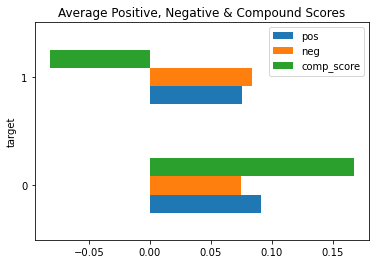

In [23]:
df_sent.groupby('target').mean()[['pos', 'neg', 'comp_score']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores');

Looking at the above graph, particularly the mean compound score, we can see that on average, r/LegalAdvice posts tend to have a relatively negative sentiment, whilst r/MaliciousCompliance posts have a more positive sentiment, with average compound scores of -0.08 and +0.17, respectively. 

#### Word Count and Frequency

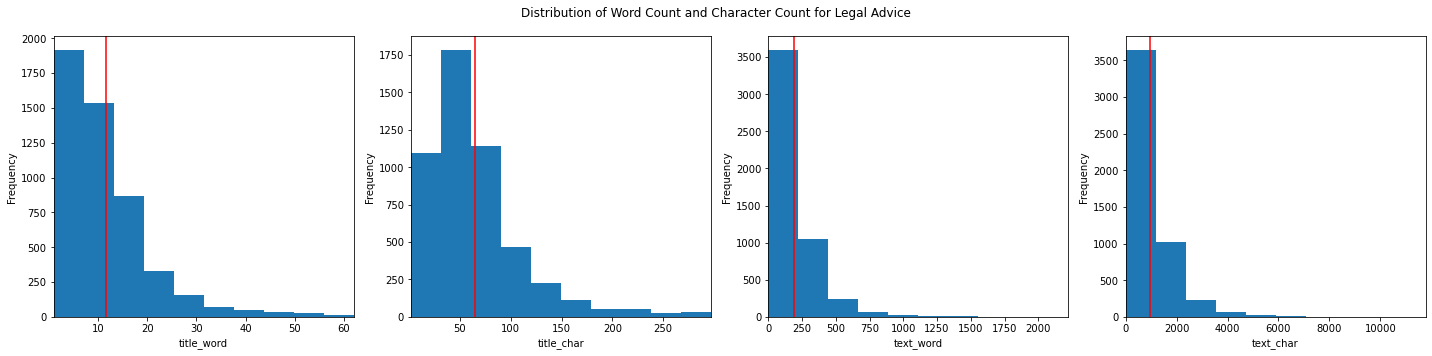

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.subplots_adjust(top=0.88)
ax = ax.ravel()
fig.suptitle("Distribution of Word Count and Character Count for Legal Advice")

for i, column in enumerate(["title_word","title_char","text_word","text_char"]):
    ax[i].hist(x=joint_df[joint_df["class"] == 1][column])
    ax[i].axvline(joint_df[joint_df["class"] == 1][column].mean(), color="red")
    ax[i].set_xlim(joint_df[joint_df["class"] == 1][column].min(),joint_df[joint_df["class"] == 1][column].max())
    ax[i].set_xlabel(column)
    ax[i].set_ylabel("Frequency")
    plt.tight_layout();

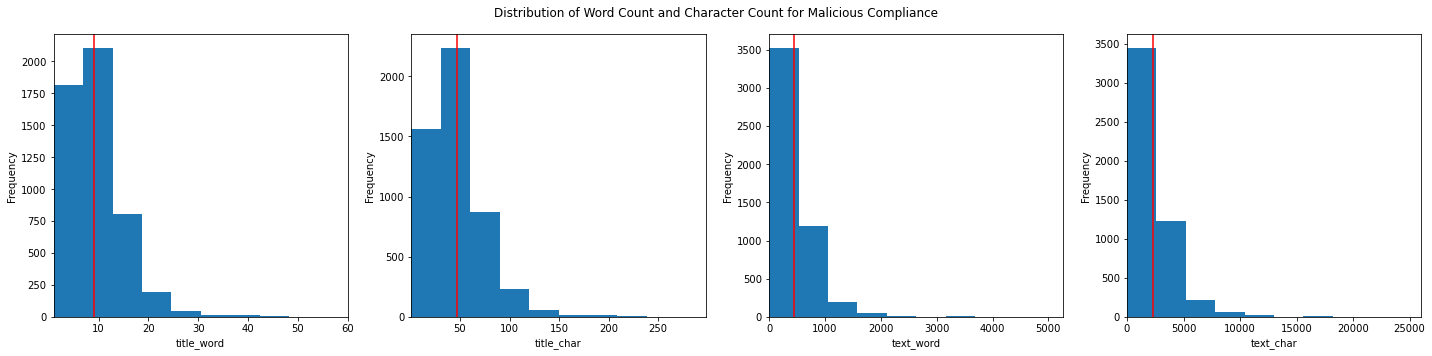

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
fig.subplots_adjust(top=0.88)
ax = ax.ravel()
fig.suptitle("Distribution of Word Count and Character Count for Malicious Compliance")

for i, column in enumerate(["title_word","title_char","text_word","text_char"]):
    ax[i].hist(x=joint_df[joint_df["class"] == 0][column])
    ax[i].axvline(joint_df[joint_df["class"] == 0][column].mean(), color="red")
    ax[i].set_xlim(joint_df[joint_df["class"] == 0][column].min(),joint_df[joint_df["class"] == 0][column].max())
    ax[i].set_xlabel(column)
    ax[i].set_ylabel("Frequency")
    plt.tight_layout();

We can observe that all word and character counts' distributions are positively skewed, which means the mean of the data is larger than both the median and mode. When comparing the word and character counts for the title and selftext we can spot an inverse relationship between title and selftext counts per subreddit. Looking at both the range and mean scores (red line on the graphs), we can see that r/LegalAdvice posts tend to have longer titles and shorter body text whilst r/MaliciousCompliance posts tend to have shorter titles but longer body text.

Below are the mean scores and range (min,max values) for the word and character counts of titles and text for both subreddits: 

In [26]:
joint_df.groupby('class').agg([np.mean,min,max])[["title_word","title_char","text_word","text_char"]]

title_word         title_char          text_word            text_char  \
            mean min max       mean min  max      mean min   max       mean   
class                                                                         
0         9.1418   1  60    46.6684   1  298  441.7508   0  5269  2262.4120   
1        11.7010   1  62    64.7472   2  297  186.9314   0  2222   970.4102   

                  
      min    max  
class             
0       0  26015  
1       0  11776

In [27]:
# Source: 5.05 NLP II

cvec = CountVectorizer(stop_words="english")

In [28]:
Xcv = cvec.fit_transform(df_sent["doc"])

In [29]:
Xcv_df = pd.DataFrame(Xcv.todense(), 
                          columns=cvec.get_feature_names())

In [30]:
Xcv_df.reset_index(drop=True, inplace=True)

In [31]:
Xcv_df["target"] = joint_df["class"]

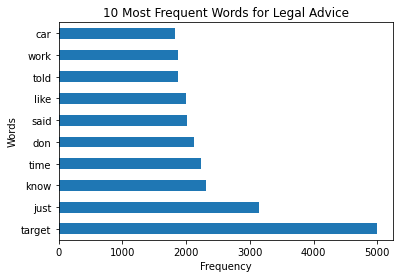

In [32]:
Xcv_df[Xcv_df["target"] == 1].sum().sort_values(ascending=False).head(10).plot(kind="barh")
plt.title('10 Most Frequent Words for Legal Advice')
plt.xlabel('Frequency')
plt.ylabel('Words');

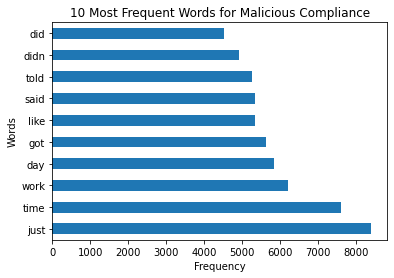

In [33]:
Xcv_df[Xcv_df["target"] == 0].sum().sort_values(ascending=False).head(10).plot(kind="barh")
plt.title('10 Most Frequent Words for Malicious Compliance')
plt.xlabel('Frequency')
plt.ylabel('Words');

At a glance, the most frequent words in both subreddits do not seem to have any specific significance (even after filtering out english stop_words), aside from "target" - the most frequent word within the r/LegalAdvice corpus. There is some overlap between the two subreddits, with common frequent words like “like”, “work", “just”, “said”, “told”.

#### Redditors Overlap Analysis

In [34]:
overlap = [redditor for redditor in legal["author"] if redditor in mc["author"]]

In [35]:
len(overlap)

0

There are no overlaps of authors from the two subreddit posts collected.

#### Datetime Analysis

As we can see below, r/LegalAdvice have more posts on Wednesday, Thursday and Friday (average posts of 1030 vs 477.5 on other days), whilst r/MaliciousCompliance seem to have a relatively stable daily post count (ranging around 606-830 posts per day).

In [36]:
joint_df["day"] = joint_df["timestamp"].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime('%a'))

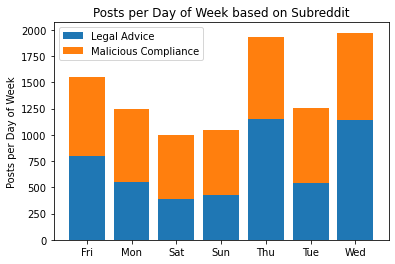

In [37]:
# source: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html

class_1 = joint_df[joint_df["class"] == 1].groupby("day")["title"].count()
class_0 = joint_df[joint_df["class"] == 0].groupby("day")["title"].count()

fig, ax = plt.subplots()

ax.bar(class_1.index, class_1,label='Legal Advice')
ax.bar(class_0.index, class_0, bottom=class_1,
       label='Malicious Compliance')

ax.set_ylabel('Posts per Day of Week')
ax.set_title('Posts per Day of Week based on Subreddit')
ax.legend()

plt.show()

In [38]:
joint_df["day"] = joint_df["day"].map(lambda x: 1 if x == "Mon"
                                      else 2 if x == "Tue"
                                      else 3 if x == "Wed"
                                      else 4 if x == "Thu"
                                      else 5 if x == "Fri"
                                      else 6 if x == "Sat"
                                      else 7 if x == "Sun"
                                      else 0)

#### Score and Comment Distribution

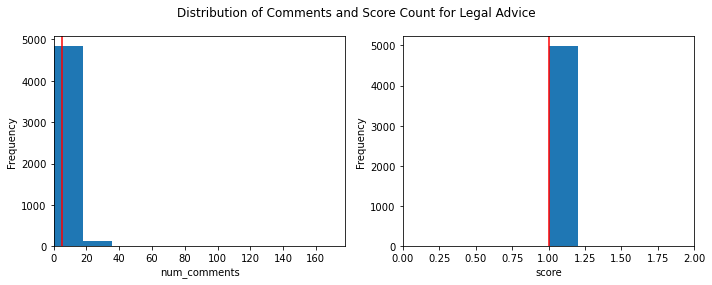

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.subplots_adjust(top=0.88)
ax = ax.ravel()
fig.suptitle("Distribution of Comments and Score Count for Legal Advice")

for i, column in enumerate(["num_comments","score"]):
    ax[i].hist(x=joint_df[joint_df["class"] == 1][column])
    ax[i].axvline(joint_df[joint_df["class"] == 1][column].mean(), color="red")
    ax[i].set_xlim(joint_df[joint_df["class"] == 1][column].min(),joint_df[joint_df["class"] == 1][column].max())
    ax[i].set_xlabel(column)
    ax[i].set_ylabel("Frequency")
    plt.tight_layout();

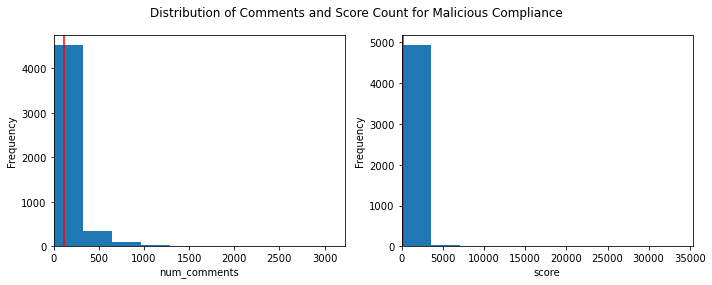

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.subplots_adjust(top=0.88)
ax = ax.ravel()
fig.suptitle("Distribution of Comments and Score Count for Malicious Compliance")

for i, column in enumerate(["num_comments","score"]):
    ax[i].hist(x=joint_df[joint_df["class"] == 0][column])
    ax[i].axvline(joint_df[joint_df["class"] == 0][column].mean(), color="red")
    ax[i].set_xlim(joint_df[joint_df["class"] == 0][column].min(),joint_df[joint_df["class"] == 0][column].max())
    ax[i].set_xlabel(column)
    ax[i].set_ylabel("Frequency")
    plt.tight_layout();

On average, r/MaliciousCompliance Posts have more comments and better scores, with a mean of 112.7 and 193.4, respectively, and a range of 0-3.2k and 0-35.3k, respectively. Whilst r/LegalAdvice have an average comment count and score of 4.9 and 1, respectively, with range of 0-178 and 0-2, respectively. 

### V. Modeling

#### Finalized Data Frame

Based on the EDA above, sentiment scores, word and character counts for both title and text, number of comments, score and day column are considered important. Being that we have created a table with sentiment scores and target, we added the other columns onto that table below.

In [41]:
df_sent[["title_word","title_char","text_word","text_char","num_comments","score","day"]] = joint_df[["title_word","title_char","text_word","text_char","num_comments","score","day"]]

##### Determining X and Y

In [42]:
X = df_sent.drop(columns=["target"])
y = df_sent["target"]

##### Train Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify = y)

##### TFDF Vectorizer

From the above EDA we also learned from the results of *CountVectorizer()* that frequency does not always equal to value. Therefore, for the model we are using TFIDF Vectorizer, which not only counts the words within the document, but penalizes it based on how often they appear in the corpus which may reduce error from bias as a result of frequent (non-valuable) words. 

Aside from using english stopwords, we have added the subreddit names as additional stop_words to ensure that the model is not reliant on words that we know are specific to each subreddits to perform well. 

In [44]:
# Source: 5.05 NLP II

add_stop_words = ["malicious","compliance","legal","advice"]

In [45]:
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [46]:
tvec = TfidfVectorizer(stop_words=stop_words)

In [47]:
X_train_tvec = tvec.fit_transform(X_train["doc"])
X_test_tvec = tvec.transform(X_test["doc"])

In [48]:
df_X_train= pd.DataFrame(X_train_tvec.todense(),columns = tvec.get_feature_names())
df_X_test = pd.DataFrame(X_test_tvec.todense(),columns = tvec.get_feature_names())

In [49]:
df_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

In [50]:
X_train_all = pd.concat([df_X_train,X_train],axis = 1)
X_train_all.head(3)

,00,000,0000,0002,000lbs,000plus,000rub,000th,001,002,...,pos,comp_score,doc,title_word,title_char,text_word,text_char,num_comments,score,day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.059,-0.9362,Friend Died and No obituary How to find out how he died if no obituary An old friend from college passed away in February I think His wife is not sharing any details only communicates with somethi...,15,70,101,568,4,1,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061,-0.9620,USPS delivered my package that was mishandled and damaged the apartment complex's lobby Hello I'm looking for advice regarding a package incident in my apartment complex lobby which also acts as o...,13,87,245,1290,2,1,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.193,0.9888,Can I bill an estate for vet bills He didn't leave a will I couldn't think of who to ask Any advice would be appreciated My father passed away yesterday and didn't leave a will He wasn't married ...,13,58,182,899,2,1,3


In [51]:
X_test_all = pd.concat([df_X_test,X_test],axis = 1)
X_test_all.head(3)

,00,000,0000,0002,000lbs,000plus,000rub,000th,001,002,...,pos,comp_score,doc,title_word,title_char,text_word,text_char,num_comments,score,day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.110,0.9682,“Why is my child in the same stall as another kid I’ve coached basketball as a volunteer for years and about 15 years ago I was coaching 8 year olds at the YMCA One of the sayings I used to say a...,11,50,242,1165,3,1,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.082,0.0484,I can't schedule time for a doctor's appointment I need to schedule a doctor's appointment but the problem is my work isn't letting me We get our schedules on Thursday the week before which is nev...,8,48,170,853,3,1,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106,0.8658,I can live without my Clown coffee* Was at a drive-thru with a coupon that allows me to get a free item of equal or lesser value with the purchase of any item so I decided to get 2 double 0.1133 k...,7,35,109,544,30,5,2


In [52]:
X_train_all.drop(columns=["doc","timestamp"],inplace=True)
X_test_all.drop(columns=["doc","timestamp"],inplace=True)

In [53]:
X_train_all.shape, X_test_all.shape

((7500, 34758), (2500, 34758))

#### 1. Baseline Model

The baseline model is 50% - this is the accuracy score we have to beat

In [54]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

#### 2. Logistic Regression

In [55]:
sc = StandardScaler(with_mean = False)
Z_train = sc.fit_transform(X_train_all)
Z_test = sc.transform(X_test_all)

In [56]:
logreg = LogisticRegression(penalty = "l1",
                        C = 0.1,
                        solver = "liblinear")

In [57]:
%%time
logreg.fit(Z_train,y_train)

CPU times: user 2.63 s, sys: 1.09 s, total: 3.72 s
Wall time: 4.31 s


LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

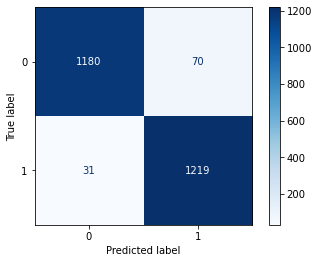

In [58]:
# Source: 4.07 Classification Metrics II

preds_logreg = logreg.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()

plot_confusion_matrix(logreg, Z_test, y_test, cmap='Blues', values_format='d');

In [59]:
logreg_train_score = logreg.score(Z_train,y_train)
logreg_test_score = logreg.score(Z_test,y_test)
logreg_test_sensitivity = tp / (tp + fn)
logreg_test_specificty = tn / (tn + fp)
logreg_roc_auc = roc_auc_score(y_test,logreg.predict_proba(Z_test)[:,1])

In [60]:
print(f'Logistic Regression Train Accuracy: {logreg_train_score}')
print(f'Logistic Regression Test Accuracy: {logreg_test_score}')
print(f'Logistic Regression Test Sensitivity: {logreg_test_sensitivity}')
print(f'Logistic Regression Test Specificity: {logreg_test_specificty}')
print(f'Logistic Regression Test ROC-AUC Score: {logreg_roc_auc}')

Logistic Regression Train Accuracy: 0.9994666666666666
Logistic Regression Test Accuracy: 0.9596
Logistic Regression Test Sensitivity: 0.9752
Logistic Regression Test Specificity: 0.944
Logistic Regression Test ROC-AUC Score: 0.9913676800000001


Overall performance of the Logistic Regression Model is really good, with a slight overfit towards the training data by 4%. We can also observe that the model is more likely to predict True Positives (sensitivity of 98%) than True Negatives (specificity of 94%), with 29 False Negatives and 69 False Positives - however there is not too much of a significant difference (~4%). Looking at the ROC-AUC score we know that the model is able to distinguish between classes almost perfectly at 99%.

#### 2. Decision Tree

In [61]:
dt = DecisionTreeClassifier(max_depth = 7,
                            min_samples_split = 20,
                            min_samples_leaf = 5,
                            ccp_alpha = 0.001,
                            random_state = 42)

In [62]:
%%time
dt.fit(X_train_all,y_train)

CPU times: user 5.17 s, sys: 1.41 s, total: 6.59 s
Wall time: 6.11 s


DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7, min_samples_leaf=5,
                       min_samples_split=20, random_state=42)

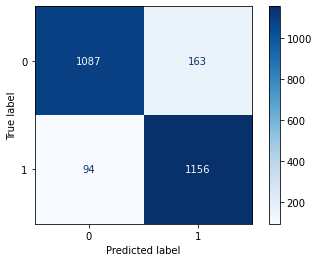

In [63]:
# Source: 4.07 Classification Metrics II

preds_dt = dt.predict(X_test_all)

tn, fp, fn, tp = confusion_matrix(y_test, preds_dt).ravel()

plot_confusion_matrix(dt, X_test_all, y_test, cmap='Blues', values_format='d');

In [64]:
dt_train_score = dt.score(X_train_all,y_train)
dt_test_score = dt.score(X_test_all,y_test)
dt_test_sensitivity = tp / (tp + fn)
dt_test_specificty = tn / (tn + fp)
dt_roc_auc = roc_auc_score(y_test,dt.predict_proba(X_test_all)[:,1])

In [65]:
print(f'Decision Tree Train Accuracy: {dt_train_score}')
print(f'Decision Tree Test Accuracy: {dt_test_score}')
print(f'Decision Tree Test Sensitivity: {dt_test_sensitivity}')
print(f'Decision Tree Test Specificity: {dt_test_specificty}')
print(f'Decision Tree Test ROC-AUC Score: {dt_roc_auc}')

Decision Tree Train Accuracy: 0.9112
Decision Tree Test Accuracy: 0.8972
Decision Tree Test Sensitivity: 0.9248
Decision Tree Test Specificity: 0.8696
Decision Tree Test ROC-AUC Score: 0.93049888


Overall performance of the Decision Tree Model is good, with a very slight overfit towards the training data by ~1%. We can also observe that the model is more likely to predict True Positives (sensitivity of 92%) than True Negatives (specificity of 87%), with 94 False Negatives and 163 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes by 93%.

In [66]:
d_dt = {'Column Name':X_train_all.columns,'Feature Importance':dt.feature_importances_}
fi_dt = pd.DataFrame(d_dt)
fi_dt.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
34755,num_comments,0.781778
34753,text_word,0.084223
30677,teacher,0.020103
34752,title_char,0.019040
29602,story,0.011264
19276,mc,0.009929
13287,funny,0.009466
34756,score,0.009406
28059,situation,0.006716
6476,claims,0.005946


Above are the top 10 most important features in the Decision Tree Model. Note that columns from the original dataframe (num_comments and score) and engineered features (text_word and title_char) are part of this.

#### 3. Random Forest

In [67]:
rfc = RandomForestClassifier(max_depth = 20,
                             max_features = "auto",
                             min_samples_leaf = 2,
                             min_samples_split = 3,
                             n_estimators = 703,
                             random_state = 42)

In [68]:
%%time
rfc.fit(X_train_all,y_train)

CPU times: user 56.6 s, sys: 1.44 s, total: 58.1 s
Wall time: 58.6 s


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=703, random_state=42)

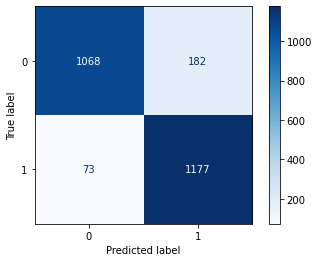

In [69]:
# Source: 4.07 Classification Metrics II

preds_rfc = rfc.predict(X_test_all)

tn, fp, fn, tp = confusion_matrix(y_test, preds_rfc).ravel()

plot_confusion_matrix(rfc, X_test_all, y_test, cmap='Blues', values_format='d');

In [70]:
rfc_train_score = rfc.score(X_train_all,y_train)
rfc_test_score = rfc.score(X_test_all,y_test)
rfc_test_sensitivity = tp / (tp + fn)
rfc_test_specificty = tn / (tn + fp)
rfc_roc_auc = roc_auc_score(y_test,rfc.predict_proba(X_test_all)[:,1])

In [71]:
print(f'Random Forest Train Accuracy: {rfc_train_score}')
print(f'Random Forest Test Accuracy: {rfc_test_score}')
print(f'Random Forest Test Sensitivity: {rfc_test_sensitivity}')
print(f'Random Forest Test Specificity: {rfc_test_specificty}')
print(f'Random Forest Test ROC-AUC Score: {rfc_roc_auc}')

Random Forest Train Accuracy: 0.9401333333333334
Random Forest Test Accuracy: 0.898
Random Forest Test Sensitivity: 0.9416
Random Forest Test Specificity: 0.8544
Random Forest Test ROC-AUC Score: 0.96381248


Overall performance of the Random Forest Model is good, with a slight overfit towards the training data by 4%. We can also observe that the model is more likely to predict True Positives (sensitivity of 94%) than True Negatives (specificity of 85%), with 73 False Negatives and 182 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes by 96%.

In [72]:
d_rfc = {'Column Name':X_train_all.columns,'Feature Importance':rfc.feature_importances_}
fi_rfc = pd.DataFrame(d_rfc)
fi_rfc.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
34755,num_comments,0.048796
34753,text_word,0.021576
34754,text_char,0.018450
8614,day,0.014527
31255,time,0.012536
29602,story,0.009158
34756,score,0.009119
33903,went,0.008380
13915,got,0.008348
9403,didn,0.008226


Above are the top 10 most important features in the Random Forest Model. Note that columns from the original dataframe (num_comments and score) and engineered features (text_word and text_char) are part of this.

#### 4. Extra Trees

In [73]:
et = ExtraTreesClassifier(bootstrap = False,
                          class_weight = "balanced",
                          max_depth = 19,
                          max_features = "auto",
                          min_samples_leaf = 2,
                          min_samples_split = 4,
                          n_estimators = 192,
                          random_state = 42
                         )

In [74]:
%%time
et.fit(X_train_all,y_train)

CPU times: user 13.4 s, sys: 1.01 s, total: 14.4 s
Wall time: 14.5 s


ExtraTreesClassifier(class_weight='balanced', max_depth=19, min_samples_leaf=2,
                     min_samples_split=4, n_estimators=192, random_state=42)

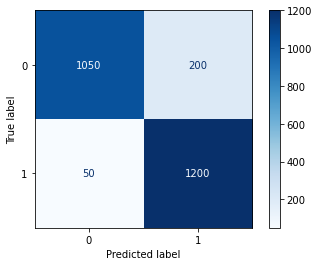

In [75]:
# Source: 4.07 Classification Metrics II

preds_et = et.predict(X_test_all)

tn, fp, fn, tp = confusion_matrix(y_test, preds_et).ravel()

plot_confusion_matrix(et, X_test_all, y_test, cmap='Blues', values_format='d');

In [76]:
et_train_score = et.score(X_train_all,y_train)
et_test_score = et.score(X_test_all,y_test)
et_test_sensitivity = tp / (tp + fn)
et_test_specificty = tn / (tn + fp)
et_roc_auc = roc_auc_score(y_test,et.predict_proba(X_test_all)[:,1])

In [77]:
print(f'Extra Trees Train Accuracy: {et_train_score}')
print(f'Extra Trees Test Accuracy: {et_test_score}')
print(f'Extra Trees Test Sensitivity: {et_test_sensitivity}')
print(f'Extra Trees Test Specificity: {et_test_specificty}')
print(f'Extra Trees Test ROC-AUC Score: {et_roc_auc}')

Extra Trees Train Accuracy: 0.9257333333333333
Extra Trees Test Accuracy: 0.9
Extra Trees Test Sensitivity: 0.96
Extra Trees Test Specificity: 0.84
Extra Trees Test ROC-AUC Score: 0.96499392


Overall performance of the Extra Trees Model is pretty good, with a slight overfit towards the training data by ~3%. We can also observe that the model is more likely to predict True Positives (sensitivity of 96%) than True Negatives (specificity of 84%), with 50 False Negatives and 200 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes by 96%.

In [78]:
d_et = {'Column Name':X_train_all.columns,'Feature Importance':et.feature_importances_}
fi_et = pd.DataFrame(d_et)
fi_et.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
34753,text_word,0.013017
34750,comp_score,0.012367
34754,text_char,0.011058
17565,knew,0.008690
2827,appreciated,0.007942
31413,told,0.006626
34755,num_comments,0.006314
4754,boss,0.005826
17948,lease,0.005811
25527,reminded,0.005720


Above are the top 10 most important features in the Extra Trees Model. Note that columns from the original dataframe (num_comments) and engineered features (text_word, text_char, comp_score) are part of this.

#### 5. Support Vector Machines

In [79]:
svc = SVC(gamma="scale",
          C=10000,
          degree = 2,
          kernel="poly"
         )

In [80]:
%%time
svc.fit(X_train_all,y_train)

CPU times: user 14min 34s, sys: 4.75 s, total: 14min 38s
Wall time: 14min 40s


SVC(C=10000, degree=2, kernel='poly')

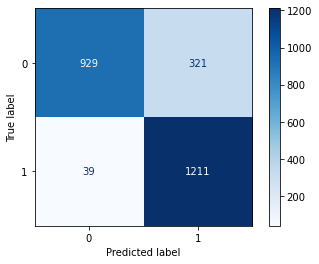

In [81]:
# Source: 4.07 Classification Metrics II

preds_svc = svc.predict(X_test_all)

tn, fp, fn, tp = confusion_matrix(y_test, preds_svc).ravel()

plot_confusion_matrix(svc, X_test_all, y_test, cmap='Blues', values_format='d');

In [82]:
svc_train_score = svc.score(X_train_all,y_train)
svc_test_score = svc.score(X_test_all,y_test)
svc_test_sensitivity = tp / (tp + fn)
svc_test_specificty = tn / (tn + fp)
svc_roc_auc = roc_auc_score(y_test,et.predict_proba(X_test_all)[:,1])

In [83]:
print(f'Support Vector Machine Train Accuracy: {svc_train_score}')
print(f'Support Vector Machine Test Accuracy: {svc_test_score}')
print(f'Support Vector Machine Test Sensitivity: {svc_test_sensitivity}')
print(f'Support Vector Machine Test Specificity: {svc_test_specificty}')
print(f'Support Vector Machine Test ROC-AUC Score: {svc_roc_auc}')

Support Vector Machine Train Accuracy: 0.8514666666666667
Support Vector Machine Test Accuracy: 0.856
Support Vector Machine Test Sensitivity: 0.9688
Support Vector Machine Test Specificity: 0.7432
Support Vector Machine Test ROC-AUC Score: 0.96499392


Overall performance of the SVM model is good, but not as good when compared to the other models above, with accuracy of 87% for testing data. This is the only model that does not overfit towards the Training data. We can also observe that the model is more likely to predict True Positives (sensitivity of 97%) than True Negatives (specificity of 74%), with 39 False Negatives and 321 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes by 97%.

#### 6. Naive Bayes

In [84]:
mnb = MultinomialNB()

In [85]:
X_train_mnb = X_train_all.drop(columns = ["comp_score"])
X_test_mnb = X_test_all.drop(columns = ["comp_score"])

In [86]:
%%time
mnb.fit(X_train_mnb,y_train)

CPU times: user 706 ms, sys: 1.11 s, total: 1.81 s
Wall time: 2.56 s


MultinomialNB()

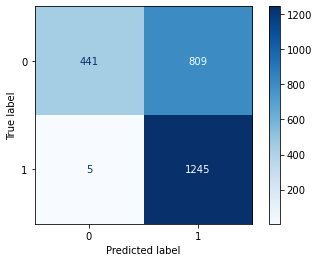

In [87]:
preds_mnb = mnb.predict(X_test_mnb)

tn, fp, fn, tp = confusion_matrix(y_test, preds_mnb).ravel()

plot_confusion_matrix(mnb, X_test_mnb, y_test, cmap='Blues', values_format='d');

In [88]:
mnb_train_score = mnb.score(X_train_mnb,y_train)
mnb_test_score = mnb.score(X_test_mnb,y_test)
mnb_test_sensitivity = tp / (tp + fn)
mnb_test_specificty = tn / (tn + fp)
mnb_roc_auc = roc_auc_score(y_test,mnb.predict_proba(X_test_mnb)[:,1])

In [89]:
print(f'Naive Bayes Train Accuracy: {mnb_train_score}')
print(f'Naive Bayes Test Accuracy: {mnb_test_score}')
print(f'Naive Bayes Test Sensitivity: {mnb_test_sensitivity}')
print(f'Naive Bayes Test Specificity: {mnb_test_specificty}')
print(f'Naive Bayes Test ROC-AUC Score: {mnb_roc_auc}')

Naive Bayes Train Accuracy: 0.6822666666666667
Naive Bayes Test Accuracy: 0.6744
Naive Bayes Test Sensitivity: 0.996
Naive Bayes Test Specificity: 0.3528
Naive Bayes Test ROC-AUC Score: 0.7003961599999999


The Naive Bayes model was the worst performing model with a test accuracy score of 67%. It is also slightly overfit towards the training by 1%. We can also observe that the model is significantly more likely to predict True Positives (sensitivity of 99%) than True Negatives (specificity of 35%), with 5 False Negatives and 809 False Positives. Looking at the ROC-AUC score we know that the model is able to distinguish between classes by 70%. The low performance may be attributed towards having to drop the sentiment compound score column because Naive Bayes Model cannot take in negative values - this shows the importance of the compound score in determining the target class.

###### Note: 
*RandomizedSearchCV and BayesSearchCV was used to determine the best hyperparameters for each model used above, but for the sake of processing speed the step is removed from within the code itself*

### VI. Evaluation

In [90]:
metrics_summary_dic = {
    "Metrics":["Train Accuracy","Test Accuracy","Test Sensitivity","Test Specificity","Test ROC-AUC Score"],
    "Logistic Regression":[logreg_train_score,logreg_test_score,logreg_test_sensitivity,logreg_test_specificty,logreg_roc_auc],
    "Decision Tree Classifier":[dt_train_score,dt_test_score,dt_test_sensitivity,dt_test_specificty,dt_roc_auc],
    "Random Forest Classifier":[rfc_train_score,rfc_test_score,rfc_test_sensitivity,rfc_test_specificty,rfc_roc_auc],
    "Extra Trees Classifier":[et_train_score,et_test_score,et_test_sensitivity,et_test_specificty,et_roc_auc],
    "Support Vector Machines":[svc_train_score,svc_test_score,svc_test_sensitivity,svc_test_specificty,svc_roc_auc],
    "Naive Bayes":[mnb_train_score,mnb_test_score,mnb_test_sensitivity,mnb_test_specificty,mnb_roc_auc]
}

In [91]:
metrics_summary = pd.DataFrame(metrics_summary_dic)
metrics_summary.set_index("Metrics", inplace=True)

In [92]:
metrics_summary = round(metrics_summary[metrics_summary.columns],3)

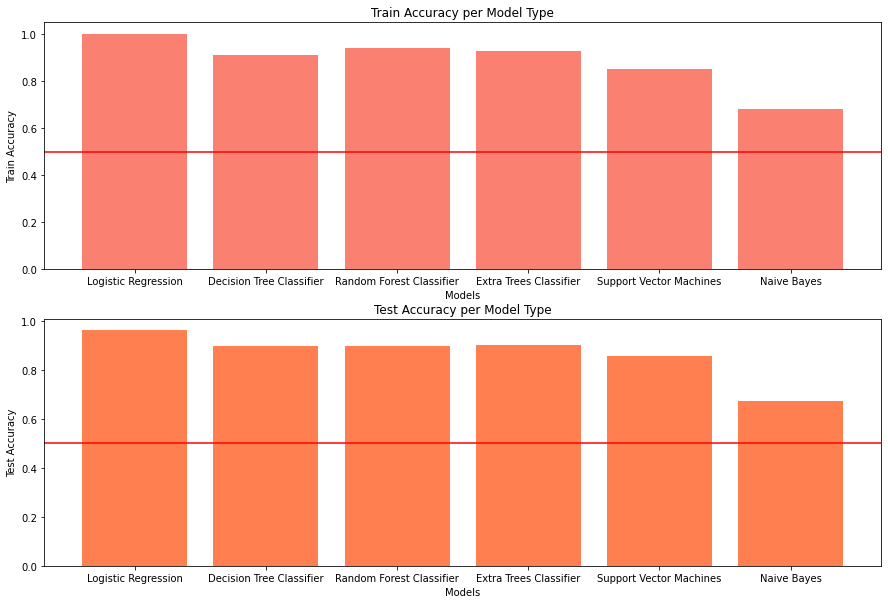

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
ax = ax.ravel()

for i, column in enumerate(["Train Accuracy","Test Accuracy"]):
    ax[i].bar(x = metrics_summary.T.index, height = metrics_summary.T[column], color=['salmon','coral'][i])
    ax[i].axhline(0.5,color="red",label="Baseline Model")
    ax[i].set_title(column + " per Model Type")
    ax[i].set_xlabel("Models")
    ax[i].set_ylabel(column)

In [94]:
metrics_summary

,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Extra Trees Classifier,Support Vector Machines,Naive Bayes
Metrics,,,,,,
Train Accuracy,0.999,0.911,0.940,0.926,0.851,0.682
Test Accuracy,0.960,0.897,0.898,0.900,0.856,0.674
Test Sensitivity,0.975,0.925,0.942,0.960,0.969,0.996
Test Specificity,0.944,0.870,0.854,0.840,0.743,0.353
Test ROC-AUC Score,0.991,0.930,0.964,0.965,0.965,0.700


Overall we can observe a slight overfit for all models except for SVM, ranging from around a 1% to 4% difference between Train and Test. All models performed better than the baseline model as seen on the graphs above, but out of all 6 models Logistic Regression has the best overall performance.

### VII. Conclusion and Recommendation

From the above results we can conclude that the best model for the client to use is Logistic Regression because it is able to accurately determine class with 96% accuracy and an ROC-AUC score of 99%. Although it is not as good in classifying true positives when compared to Naive Bayes (97.7% vs 99.6%) it is still relatively high and has the highest specificity score of 94%. A balance of the two is important in this case because we would not want to get many false positives (important messages not filtered out because it is categorized as legal-related when it is not) or false negatives (important messages filtered out because it is categorized as non-legal-related when it is). 

However I do recommend potentially trying different models (i.e. ensemble models like XGBoost) and/or removing features (limiting TFIDF Vectorized max features, lemmatizing or stemming words) to avoid overfitting. It is also possible to remove features that are reddit specific like number of comments and scores which would not necessarily add value for the client's purpose. 